TIER 1:\
set up the prediction lstm on amazon data, and \
set up data-scraping from key stock website 

TIER 2:\
try to have it save and load models from a folder\
also only keep 5 models at a time, delete old ones\
test a variety of parameters of the lstm automatically, retain and save only the best ones

In [176]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from datetime import datetime
from bs4 import BeautifulSoup
import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import seaborn as sns

<h3>Preprocess all data</h3>
Make sure we split before we feature scale train and test (TODO)

In [177]:
initial = False # True if we have no data - tweaks may be needed
scaler = MinMaxScaler(feature_range=(-1, 1))
x_scaler = StandardScaler()
y_scaler = StandardScaler()

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100 # 100 originally, 150 seems to give good results 
num_tune_epochs = 3 # recommended to keep # of training epochs between 3 and 10 when fine-tuning models (3-5 for simple ones) 

# True for Train, False for Load
train_or_load_original = True # separate modifier because original model's performance is very unreliable
train_or_load_new = True
train_or_load = True
train_or_load_gru = True

In [178]:
def save_data(data, date = None):
    if not date:
        date = f"{str(datetime.now()).replace(':','.')}.csv"
    os.makedirs("data", exist_ok=True)
    contents = os.listdir("data")
    for item in contents:
        if date[:10] in item:
            os.remove("data/" + item)
    if f"data/{date}" not in os.listdir("data"):
        data.to_csv("data/" + date, index=False)
        
def read_data(filepath, sort_column = None):
    data = pd.read_csv(filepath)
    if sort_column:
        data = data.sort_values(sort_column)
    data.head()
    price = data[['Close']] 
    price['Close'] = price['Close'].values.reshape(-1,1)
    # price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1)) # Problematic line
    return data, price

In [179]:
data = pd.read_csv("relevant-stock-data/AMZN Historical Data Fixed.csv")
data = data.iloc[::-1]
data = data[['Date', 'Open', 'High', 'Low', 'Price', 'Vol.']]
data = data.rename(columns={'Price' : 'Close', 'Vol.' : 'Volume'})
data['Name'] = ['AMZN']*len(data['Date'])

for i in range(len(data['Volume'])): # iloc for integer based assignment of multiple cells, iat for integer based assignment on a single cell
    if 'M' in data['Volume'].iat[i]:
        data['Volume'].iat[i] = str(int(float(data['Volume'].iat[i][:-1]) * 1e6))
    if 'B' in data['Volume'].iat[i]:
        data['Volume'].iat[i] = str(int(float(data['Volume'].iat[i][:-1]) * 1e9))

price = data[['Close']]
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
print(price.iloc[-5:])
print(data.iloc[-5:])

      Close
4  0.836165
3  0.899547
2  0.913822
1  0.859281
0  0.892623
         Date    Open    High     Low   Close    Volume  Name
4  04/25/2024  169.68  173.92  166.32  173.67  49250000  AMZN
3  04/26/2024  177.79  180.82  176.13  179.62  43920000  AMZN
2  04/29/2024  182.65  183.50  179.39  180.96  52080000  AMZN
1  04/30/2024  181.01  182.02  175.05  175.84  61800000  AMZN
0  05/01/2024  181.68  185.12  176.57  178.97  87860000  AMZN


C:\Users\noten\AppData\Local\Temp\ipykernel_44804\620714233.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


<h3>TODO: Change sampling of values to random so that the model has a view across the entire data, not just the oldest 80% of values.</h3>
Also, try implementing a regression model and have it train, save, fine-tune, and load w/ the other models

In [180]:
def split_data(data, stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    print(data.shape)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    # scaler.fit(np.squeeze(data[:train_set_size,:,0])) # scaler should scale based off of training mean and std ONLY.
    
    x_train = data[:train_set_size,:-1,:]
    x_train[:,:,0] = x_scaler.fit_transform(x_train[:,:,0])
    # print(x_train)
    
    y_train = y_scaler.fit_transform(data[:train_set_size,-1,:])
    # print(y_train)
    
    # y_train = scaler.transform(data[:train_set_size,-1,:])
    
    x_test = data[train_set_size:,:-1]
    x_test[:,:,0] = x_scaler.transform(x_test[:,:,0])
    y_test = y_scaler.transform(data[train_set_size:,-1,:])
    
    return [x_train, y_train, x_test, y_test]

In [181]:
# 0 for the original, 1 for our new lstm and gru, 2 for the expanded lstm 
# expected to have many models - lists preferred over dictionaries
x_trains = []
y_trains_lstm = []
x_tests = []
y_tests_lstm = []

In [182]:
lookback = 20 # choose sequence length

x_train, y_train, x_test, y_test = split_data(data, price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(4593, 20, 1)
x_train.shape =  (3674, 19, 1)
y_train.shape =  (3674, 1)
x_test.shape =  (919, 19, 1)
y_test.shape =  (919, 1)


In [183]:
# Convert arrays to Pytorch arrays using .from_numpy()
# Set type to torch tensors using .type(torch.Tensor)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_trains.append(x_train)
x_tests.append(x_test)
y_trains_lstm.append(y_train_lstm)
y_tests_lstm.append(y_test_lstm)

In [184]:
# is this necessary? data kinda already fulfills this purpose

if not initial:
    print("data/" + os.listdir("data")[-1]) # do we save the wrong data?
    data = pd.read_csv("data/" + os.listdir("data")[-1])

data/2024-05-14 22.40.45.104494.csv


Automatically Updating Data

In [185]:
cur_time = int(str(datetime.now())[11:13])
print(cur_time) # the current hour
# While today is not in the data, keep adding rows
most_recent_date = data['Date'].iloc[-1]
# most_recent_date = most_recent_date[-4:] + "-" + most_recent_date[:2] + "-" + most_recent_date[3:5] 
print(most_recent_date) # broken lol
print(str(datetime.now())[:10])

23
05/14/2024
2024-05-14


In [186]:
def get_updated_data():
    count_today = cur_time >= 16 # has the market closed yet? T if yes, F if no.
    url = "https://www.investing.com/equities/amazon-com-inc-historical-data"
    page = requests.get(url)
        
    soup = BeautifulSoup(page.text, 'html.parser')
        
    # Need: Open, High, Low, Close, Volume, Name
    all_date_class = "freeze-column-w-1 w-full overflow-x-auto text-xs leading-4"
    table = soup.find('table', {'class': all_date_class})
    rows = table.find_all('tr')
    
    table_data = []
    for row in rows:
        row_data = []
        for cell in row.find_all(['td']):
            row_data.append(cell.text)
        if row_data and count_today:
            
            for i in range(len(row_data)):
                if 'M' in row_data[i]:
                    row_data[i] = str(int(float(row_data[i][:-1]) * 1e6)) # all data values are rounded so we round too
            # print(row_data)
            if most_recent_date in row_data:
                break # we've caught up
            table_data.append(row_data)
        else:
            count_today = True

    # print(table_data)
    return table_data

get_updated_data()

[]

In [187]:
date_updated = most_recent_date[-4:] + "-" + most_recent_date[:2] + "-" + most_recent_date[3:5] 
need_update = not date_updated == str(datetime.now())[:10] and cur_time >= 16
print(need_update)

if need_update:
    # old_data = pd.read_csv('data/' + os.listdir('data')[-1])

    # for now, we will only focus on updating day by day
    new_data = get_updated_data()[::-1] # newest dates are returned first
    start_index = len(data['Date'])
        
    for i in range(len(new_data)): # adds data backwards, please fix
        new_values = new_data[i] # comes as date, price (close), open, high, low, vol, change
    
        # new_values = get_updated_data()[0] 
        print(pd.DataFrame(new_values).head())
        
        # read, write, then save the new values inside our most recent table
        data.loc[start_index + i] = [new_values[0], new_values[2], new_values[3], new_values[4], new_values[1], new_values[5], "AMZN"] # may be deprecated in future, we'll see
    
    # print(old_data.head())
    # print(len(old_data['Date']))
    # print(old_data['Date'].iloc[-1])
    
    # result.to_csv("data/" + str(datetime.now()).replace(":",".") + ".csv", index=False)
    save_data(data)

False


In [188]:
updated_data, updated_price = read_data('data/' + os.listdir("data")[-1])
print('data/' + os.listdir("data")[-1])
print(updated_data.iloc[-5:])
print(updated_price.iloc[-5:])

data/2024-05-14 22.40.45.104494.csv
            Date    Open    High     Low   Close    Volume  Name
4617  05/08/2024  187.44  188.42  186.40  188.00  25800000  AMZN
4618  05/09/2024  188.88  191.68  187.52  189.50  42340000  AMZN
4619  05/10/2024  188.98  189.87  186.93  187.48  28560000  AMZN
4620  05/13/2024  188.00  188.18  185.36  186.57  21690000  AMZN
4621  05/14/2024  183.82  187.71  183.50  187.07  38630000  AMZN
       Close
4617  188.00
4618  189.50
4619  187.48
4620  186.57
4621  187.07


C:\Users\noten\AppData\Local\Temp\ipykernel_44804\2495495438.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = price['Close'].values.reshape(-1,1)


In [189]:
if('2024-04-26' not in str(datetime.now())): # initial date
    if need_update:
        save_data(data)  
else:
    save_data('2024-04-26 00.00.000000')
print(str(datetime.now())[:10])

2024-05-14


In [190]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(updated_data, updated_price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

# print(x_train[0])
# print(y_train[0])
# print(x_test[0])
# print(y_test[0])

(4602, 20, 1)
x_train.shape =  (3682, 19, 1)
y_train.shape =  (3682, 1)
x_test.shape =  (920, 19, 1)
y_test.shape =  (920, 1)


In [191]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_trains.append(x_train)
x_tests.append(x_test)
y_trains_lstm.append(y_train_lstm)
y_tests_lstm.append(y_test_lstm)

In [192]:
volume_scaler = MinMaxScaler(feature_range=(-1, 1)) # The volumes are in the millions and would mess up our scaler
column_scaler = StandardScaler()

In [193]:
# Expanded data
# Scale and transform the other columns ONLY HERE so that we don't save the scaled values
# For some reason, y only registers 2 dimensions, unlike the original that registers 3.
# Should look into this sometime.
def split_data_expanded(data, stock, lookback):
    data_raw = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    stock_raw = stock.to_numpy() # convert to numpy array
    x = []
    y = []
    
    # n = len(data_raw.iloc[0,:])
    # for i in range(n - 1):
    #     data_raw.iloc[:,i] = scaler.fit_transform(data_raw.iloc[:,i].values.reshape(-1,1))
    # data_raw.iloc[:,n-1] = volume_scaler.fit_transform(data_raw.iloc[:, n-1].values.reshape(-1,1))
    
    
    data_raw = data_raw.to_numpy()
    
    # create all possible sequences of length seq_len
    for index in range(len(stock_raw) - lookback): 
        x.append(data_raw[index: index + lookback])
        y.append(stock_raw[index: index + lookback])
    
    x = np.array(x)
    y = np.array(y)
    
    print(x.shape)
    print(y.shape)
    
    test_set_size = int(np.round(0.2*y.shape[0])) # 80-20 train-test split
    train_set_size = y.shape[0] - (test_set_size)
    
    # scale all values in data_raw
    # when reading in values, we only min-max the values of stock
    
    for i in range(x.shape[2]): # each category
        # scaler.fit(x[:train_set_size,:,i])
        x[:,:,i] = column_scaler.fit_transform(x[:,:,i])
        
    # x_train = y[:train_set_size,:-1,:]
    x_train = x[:train_set_size,:-1,:]
    y_train = y_scaler.fit_transform(y[:train_set_size,-1,:])
    
    # x_test = y[train_set_size:,:-1]
    x_test = x[train_set_size:,:-1,:]
    y_test = y_scaler.transform(y[train_set_size:,-1,:])
    
    return [x_train, y_train, x_test, y_test]

# Test code
test = True
if test:
    test_data, test_stock = read_data("data/" + os.listdir("data")[-1])
    print(test_data.iloc[-5:])
    x_train, y_train, x_test, y_test = split_data_expanded(test_data, test_stock, 20)
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)

            Date    Open    High     Low   Close    Volume  Name
4617  05/08/2024  187.44  188.42  186.40  188.00  25800000  AMZN
4618  05/09/2024  188.88  191.68  187.52  189.50  42340000  AMZN
4619  05/10/2024  188.98  189.87  186.93  187.48  28560000  AMZN
4620  05/13/2024  188.00  188.18  185.36  186.57  21690000  AMZN
4621  05/14/2024  183.82  187.71  183.50  187.07  38630000  AMZN
(4602, 20, 5)
(4602, 20, 1)
x_train.shape =  (3682, 19, 5)
y_train.shape =  (3682, 1)
x_test.shape =  (920, 19, 5)
y_test.shape =  (920, 1)


C:\Users\noten\AppData\Local\Temp\ipykernel_44804\2495495438.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = price['Close'].values.reshape(-1,1)


In [194]:
# train, test key is 2
x_train, y_train, x_test, y_test = split_data_expanded(updated_data, updated_price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

(4602, 20, 5)
(4602, 20, 1)
x_train.shape =  (3682, 19, 5)
y_train.shape =  (3682, 1)
x_test.shape =  (920, 19, 5)
y_test.shape =  (920, 1)


In [195]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_trains.append(x_train)
x_tests.append(x_test)
y_trains_lstm.append(y_train_lstm)
y_tests_lstm.append(y_test_lstm)

<h3>Train models - one on the provided data, rest on the collected data</h3>

<h3>Also, fine-tune the models' hyperparameters </h3>

In [196]:
model_dir = "models"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = torch.nn.MSELoss(reduction='mean')

In [197]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [198]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [199]:
original_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
original_optimiser = torch.optim.Adam(original_model.parameters(), lr=0.01)

if not train_or_load_original:
    # load original model
    loaded_state = torch.load(model_dir + "/original3.pt", map_location=device)
    original_model.load_state_dict(loaded_state['model'])
    original_optimiser.load_state_dict(loaded_state['opt'])

In [200]:
def train_model(model, optimiser, data_key, num_epochs=100):
    # print(y_scaler.inverse_transform(y_trains_lstm[data_key][-1].detach().numpy().reshape(-1, 1)))
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []

    for t in range(num_epochs):
        y_train_pred = model(x_trains[data_key])

        loss = criterion(y_train_pred, y_trains_lstm[data_key])
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return y_train_pred, hist

In [201]:
if need_update and train_or_load_original:
    y_train_pred, hist = train_model(original_model, original_optimiser, 0, num_epochs=num_epochs)

In [202]:
def graph_results(y_train_pred, hist, data_key):
    predict = pd.DataFrame(y_scaler.inverse_transform(y_train_pred.detach().numpy())) # un-normalize data
    original = pd.DataFrame(y_scaler.inverse_transform(y_trains_lstm[data_key].detach().numpy())) # un-normalzie data
    
    sns.set_style("darkgrid")    

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)


    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=hist, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')
    fig.set_figheight(6)
    fig.set_figwidth(16)

In [203]:
if need_update and train_or_load_original:
    graph_results(y_train_pred, hist, 0)

In [204]:
new_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
new_optimiser = torch.optim.Adam(new_model.parameters(), lr=0.01)

if not train_or_load_new:
    # load a previous model
    possible_models = []
    for i in os.listdir(model_dir):
        if 'stock-only-lstm' in i:
            possible_models.append(i)
            print(i)
    
    loaded_state = torch.load(model_dir + "/" + possible_models[-1], map_location=device)
    new_model.load_state_dict(loaded_state['model'])
    new_optimiser.load_state_dict(loaded_state['opt'])

In [205]:
if not train_or_load_new:
    if need_update:
        y_pred, hist = train_model(new_model, new_optimiser, 1, num_epochs=num_tune_epochs)
else:
    y_pred, hist = train_model(new_model, new_optimiser, 1, num_epochs=num_epochs)

Epoch  0 MSE:  1.0028295516967773
Epoch  1 MSE:  0.9156944155693054
Epoch  2 MSE:  0.7963904142379761
Epoch  3 MSE:  0.5793617367744446
Epoch  4 MSE:  0.28256621956825256
Epoch  5 MSE:  0.186161607503891
Epoch  6 MSE:  0.25751298666000366
Epoch  7 MSE:  0.28117474913597107
Epoch  8 MSE:  0.19630219042301178
Epoch  9 MSE:  0.1146460697054863
Epoch  10 MSE:  0.08952237665653229
Epoch  11 MSE:  0.10016119480133057
Epoch  12 MSE:  0.11447172611951828
Epoch  13 MSE:  0.11765741556882858
Epoch  14 MSE:  0.10629437863826752
Epoch  15 MSE:  0.08676978200674057
Epoch  16 MSE:  0.07186884433031082
Epoch  17 MSE:  0.06921989470720291
Epoch  18 MSE:  0.07013580948114395
Epoch  19 MSE:  0.06085605546832085
Epoch  20 MSE:  0.04215723276138306
Epoch  21 MSE:  0.02790049836039543
Epoch  22 MSE:  0.02456239052116871
Epoch  23 MSE:  0.025809524580836296
Epoch  24 MSE:  0.024564774706959724
Epoch  25 MSE:  0.020234424620866776
Epoch  26 MSE:  0.01744338870048523
Epoch  27 MSE:  0.018235724419355392
Epoch

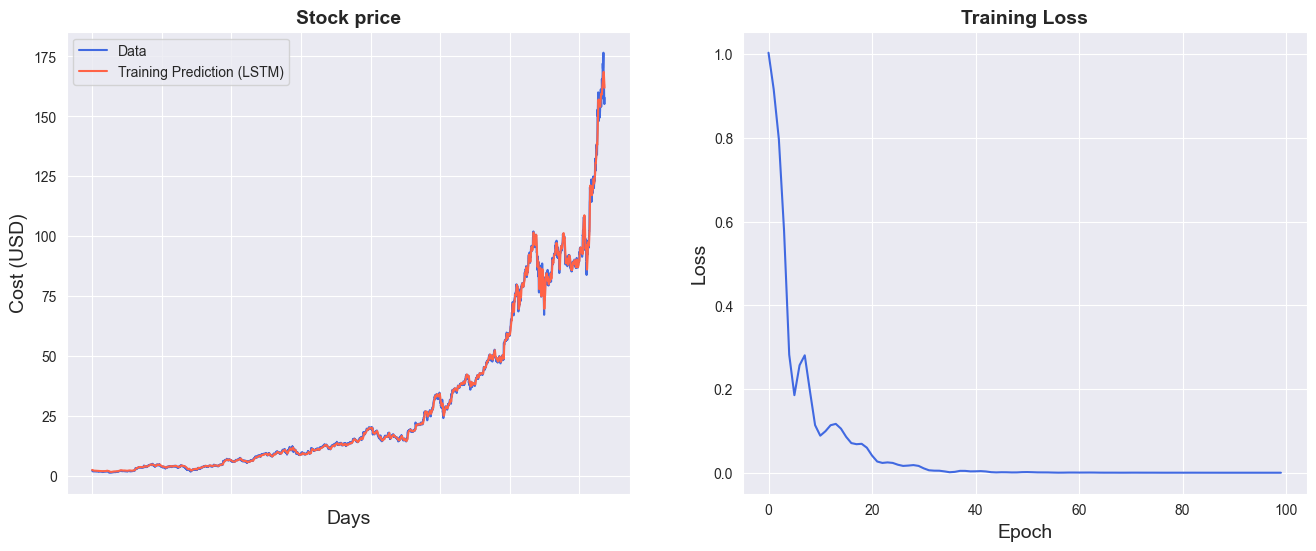

In [206]:
if need_update or train_or_load_new:
    graph_results(y_pred, hist, 1)

In [207]:
# Train a model using all traits - not just stock price
# 5 important traits - open, high, low, close, volume
# data key is 2
expanded_model = LSTM(input_dim=5, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
expanded_optimiser = torch.optim.Adam(expanded_model.parameters(), lr=0.01)

if not train_or_load:
    # load a previous model
    possible_models = []
    for i in os.listdir(model_dir):
        if 'expanded-lstm' in i:
            possible_models.append(i)
            print(i)
    
    loaded_state = torch.load(model_dir + "/" + possible_models[-1], map_location=device)
    expanded_model.load_state_dict(loaded_state['model'])
    expanded_optimiser.load_state_dict(loaded_state['opt'])

if not train_or_load:
    if need_update: 
        y_pred, hist = train_model(expanded_model, expanded_optimiser, 2, num_epochs=num_tune_epochs)
else:
    y_pred, hist = train_model(expanded_model, expanded_optimiser, 2, num_epochs=num_epochs)
    

Epoch  0 MSE:  0.9717729091644287
Epoch  1 MSE:  0.8476066589355469
Epoch  2 MSE:  0.6441077589988708
Epoch  3 MSE:  0.330454021692276
Epoch  4 MSE:  0.16362081468105316
Epoch  5 MSE:  0.12661708891391754
Epoch  6 MSE:  0.20395034551620483
Epoch  7 MSE:  0.18290118873119354
Epoch  8 MSE:  0.12081291526556015
Epoch  9 MSE:  0.08566728234291077
Epoch  10 MSE:  0.08088941127061844
Epoch  11 MSE:  0.09017644822597504
Epoch  12 MSE:  0.10039583593606949
Epoch  13 MSE:  0.10442909598350525
Epoch  14 MSE:  0.10009822249412537
Epoch  15 MSE:  0.08907242864370346
Epoch  16 MSE:  0.07530784606933594
Epoch  17 MSE:  0.06312296539545059
Epoch  18 MSE:  0.05521181598305702
Epoch  19 MSE:  0.05091848224401474
Epoch  20 MSE:  0.04654538258910179
Epoch  21 MSE:  0.039201512932777405
Epoch  22 MSE:  0.030424632132053375
Epoch  23 MSE:  0.024718327447772026
Epoch  24 MSE:  0.024379350244998932
Epoch  25 MSE:  0.025781046599149704
Epoch  26 MSE:  0.02359769307076931
Epoch  27 MSE:  0.01813449151813984
Ep

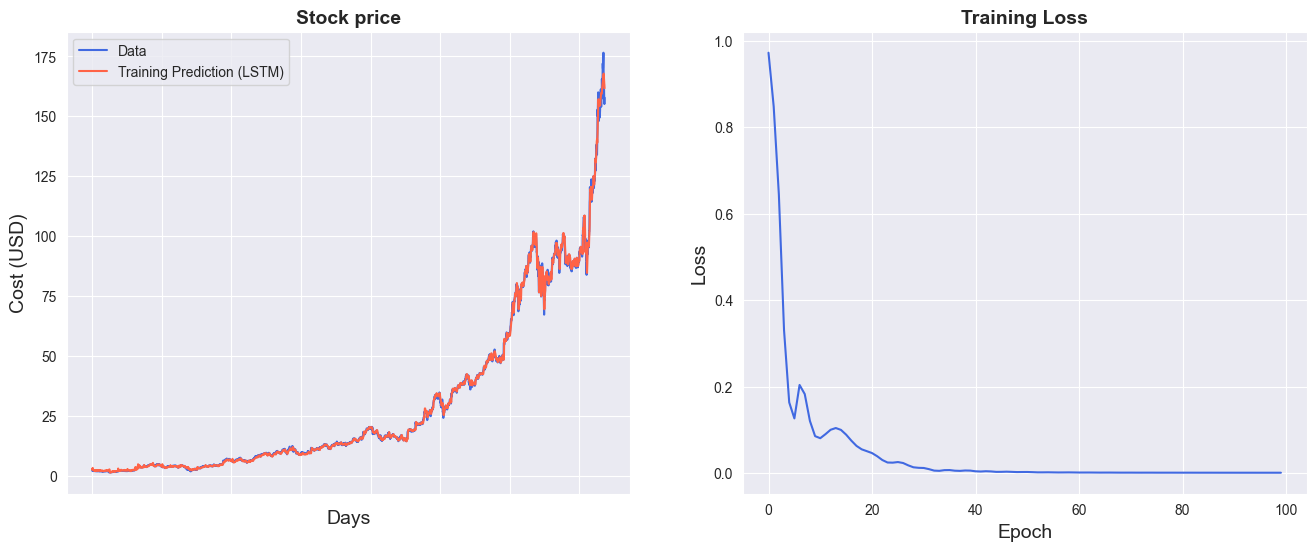

In [208]:
if need_update or train_or_load:
    graph_results(y_pred, hist, 2)

In [209]:
# use data key of 1 - same as the new lstm model
new_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
new_gru_optimiser = torch.optim.Adam(new_gru.parameters(), lr=0.01)

if not train_or_load_gru:
    # load a previous model
    possible_models = []
    for i in os.listdir(model_dir):
        if 'stock-only-gru' in i:
            possible_models.append(i)
            print(i)
    
    loaded_state = torch.load(model_dir + "/" + possible_models[-1], map_location=device)
    new_gru.load_state_dict(loaded_state['model'])
    new_gru_optimiser.load_state_dict(loaded_state['opt'])    
    if need_update:
        y_pred, hist = train_model(new_gru, new_gru_optimiser, 1, num_epochs=num_tune_epochs)
else:
    y_pred, hist = train_model(new_gru, new_gru_optimiser, 1, num_epochs=num_epochs)

Epoch  0 MSE:  1.0225690603256226
Epoch  1 MSE:  0.7263550162315369
Epoch  2 MSE:  0.4259471297264099
Epoch  3 MSE:  0.1356889009475708
Epoch  4 MSE:  0.09754437953233719
Epoch  5 MSE:  0.20662248134613037
Epoch  6 MSE:  0.15633665025234222
Epoch  7 MSE:  0.06785015016794205
Epoch  8 MSE:  0.046357981860637665
Epoch  9 MSE:  0.08397616446018219
Epoch  10 MSE:  0.10933557152748108
Epoch  11 MSE:  0.09604540467262268
Epoch  12 MSE:  0.06257940828800201
Epoch  13 MSE:  0.03614100441336632
Epoch  14 MSE:  0.03176756203174591
Epoch  15 MSE:  0.04466304928064346
Epoch  16 MSE:  0.05768213048577309
Epoch  17 MSE:  0.05783038213849068
Epoch  18 MSE:  0.04590366780757904
Epoch  19 MSE:  0.03170332685112953
Epoch  20 MSE:  0.02426396682858467
Epoch  21 MSE:  0.02583346515893936
Epoch  22 MSE:  0.03190596401691437
Epoch  23 MSE:  0.0359017588198185
Epoch  24 MSE:  0.03413292020559311
Epoch  25 MSE:  0.027576927095651627
Epoch  26 MSE:  0.020403655245900154
Epoch  27 MSE:  0.016798049211502075
Epo

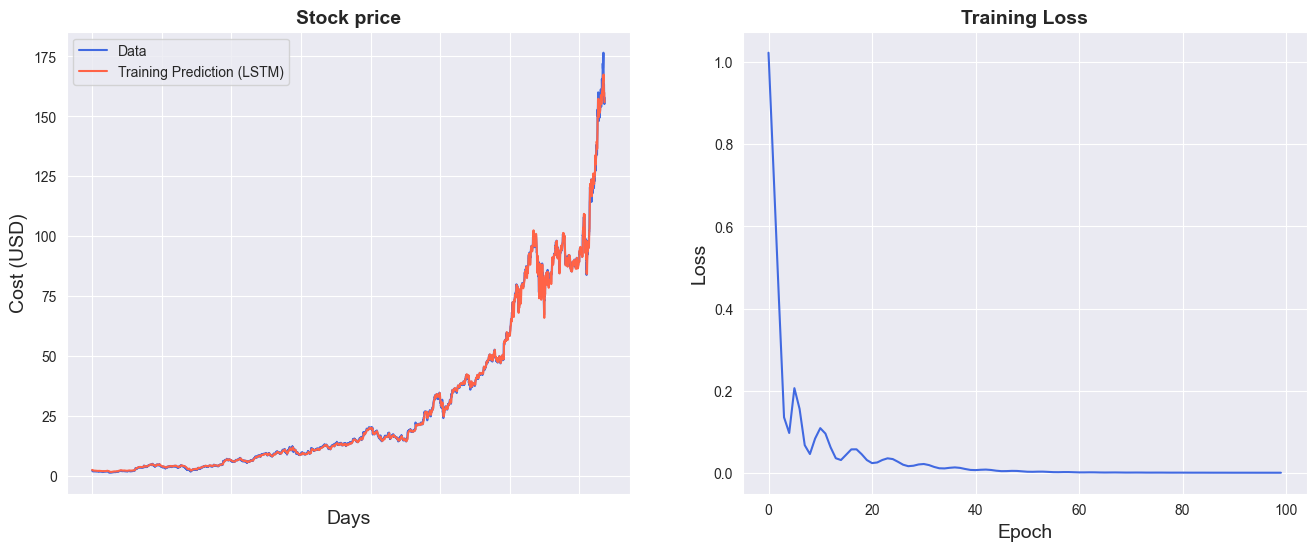

In [210]:
if need_update or train_or_load_gru:
    graph_results(y_pred, hist, 1)

<h3>Make Predictions using Models </h3>

Original and new LSTM model just do regression on the stock themselves \
Expanded model uses open, high, low, close, volume to regress stock

In [211]:
def buy_or_sell(is_buy, start, stop, prices, days):
    if is_buy:
        min_price = min(prices[start:stop])
        # print(min_price)
        for j in range(start, stop):
            if prices[j] != min_price:
                days[j] = None
    else:    
        max_sell = max(prices[start:stop])
        for j in range(start, stop):
            if prices[j] != max_sell:
                days[j] = None

def maximize_profit(prices):
    cur_hold, cur_not_hold = -float('inf'), 0
    days = [None] * len(prices)

    for i in range(len(prices)):
        # we don't have logic for taking back purchases
        stock_price = prices[i]
        prev_hold, prev_not_hold = cur_hold, cur_not_hold
        
        cur_hold = max(prev_hold, prev_not_hold - stock_price)
        if prev_hold < prev_not_hold - stock_price: # if it is more worth to buy
            days[i] = "buy"
            
        
        cur_not_hold = max(prev_not_hold, prev_hold + stock_price)
        if prev_not_hold < prev_hold + stock_price: # if it is more worth to sell
            days[i] = "sell" 

    is_buy = False
    days_to_consider = []   

    for i in range(len(days)):
        if (len(days_to_consider) > 0 and (days[i] == "buy") != is_buy):
            # print(days_to_consider)
            start, stop = days_to_consider[0], days_to_consider[-1] + 1
            buy_or_sell(is_buy, start, stop, prices, days)
            days_to_consider = []
        days_to_consider.append(i) 
        is_buy = days[i] == 'buy'
        
    if len(days_to_consider) > 0:
        buy_or_sell(is_buy, days_to_consider[0], days_to_consider[-1] + 1, prices, days) 
        
    return cur_not_hold, days

In [212]:
# predict an entire week 
# NOT compatible with the expanded LSTM - do not use!!
def predict_entire_week(model, x_pred):
    # predict an entire week's stock and return best days to buy and sell
    # try:
    # make predictions
    cur_price = int(updated_data['Close'].values[-1])
    results = [cur_price]
    today = datetime.now()
    days_left = max(0, 5-today.weekday()) if today.weekday() < 6 else 5
    for i in range(days_left):
        # pred = scaler.inverse_transform(np.array(model(x_pred).detach()))[0,0]
        # print(pred)
        # results.append(pred) 
        # x_pred = torch.cat((x_pred, torch.tensor([pred])), dim=0)
        pred = model(x_pred)
        x_pred = torch.cat((x_pred, pred.reshape(1,1,1)), dim=1)
        results.append(scaler.inverse_transform(np.array(pred.detach()))[0,0])
        
    print(results)
        
    cur_not_hold, days = maximize_profit(results)
           
    return results, days, cur_not_hold
    # except:
    #     print("Remember, don't use this on the expanded LSTM! If you didn't, then a different error occured.") 

test = True
if test:
    x_pred = []
    x_pred.append(updated_price.values[-20:].astype(np.float32))
    # print(x_pred)
    x_pred = torch.tensor(x_pred) # this should be 3D (include the previous 20 days)
    print(predict_entire_week(new_model, x_pred))


[187, 497.2456, 493.50903, 493.84903, 493.68878]
([187, 497.2456, 493.50903, 493.84903, 493.68878], ['buy', 'sell', 'buy', 'sell', 'buy'], 310.5856018066406)


In [213]:
# print(updated_price.values[-20:].astype(np.float32))

x_pred = []
x_pred.append(updated_price.values[-20:].astype(np.float32))
# print(x_pred)
x_pred = torch.tensor(x_pred) # this should be 3D (include the previous 20 days)
output_dir = "data"
date = str(datetime.now()).replace(":", ".")

next_price_original =  y_scaler.inverse_transform(np.array(original_model(x_pred).detach()))[0,0] # we need .detach to get rid of the gradient (avoiding future gradient computation)
print("Original LSTM:", next_price_original)

next_price_new = y_scaler.inverse_transform(np.array(new_model(x_pred).detach()))[0,0]
print("Updated LSTM:", next_price_new)

next_price_gru = y_scaler.inverse_transform(np.array(new_gru(x_pred).detach()))[0,0]
print("Updated GRU:", next_price_gru)

data = updated_data.iloc[-20:,1:6]
n = len(data.iloc[0,:])
for i in range(n - 1):
    data.iloc[:,i] = scaler.fit_transform(data.iloc[:,i].values.reshape(-1,1))
data.iloc[:,n-1] = volume_scaler.fit_transform(data.iloc[:, n-1].values.reshape(-1,1))
x_pred = []
x_pred.append(data.values[-20:].astype(np.float32)) # giving all values breaks it
# print(x_pred)

x_pred = torch.tensor(x_pred)

next_price_expanded = scaler.inverse_transform(np.array(expanded_model(x_pred).detach()))[0,0]
print("Expanded and Updated LSTM:", next_price_expanded)


with open("predictions/original_predictions " + date + ".txt", "w") as file:
    file.write(str(next_price_original)) # original is predicting stock values too low - needs a fix?
    
with open("predictions/new_predictions " + date + ".txt", "w") as file:
    file.write(str(next_price_new))
    
with open("predictions/new_and_expanded_predictions " + date + ".txt", "w") as file:
    file.write(str(next_price_expanded))

Original LSTM: 27.831484
Updated LSTM: 180.44754
Updated GRU: 192.2096
Expanded and Updated LSTM: 195.47578


In [214]:
folder_dir = "models"
files = os.listdir(folder_dir)
while len(os.listdir(folder_dir)) > 100:
    os.remove(folder_dir + files.pop(0))

filename = str(datetime.now()).replace(":", ".") + ".pt"

if train_or_load_original:
    torch.save({
        "model":original_model.state_dict(),
        "opt":original_optimiser.state_dict()
    }, folder_dir + "/original3.pt")
    
torch.save({ 
    "model": new_model.state_dict(),
    "opt": new_optimiser.state_dict()
}, folder_dir + "/stock-only-lstm " + filename)

torch.save({ 
    "model": expanded_model.state_dict(),
    "opt": expanded_optimiser.state_dict()
}, folder_dir + "/expanded-lstm " + filename)

torch.save({ 
    "model": new_gru.state_dict(),
    "opt": new_gru_optimiser.state_dict()
}, folder_dir + "/stock-only-gru " + filename)

<h3> Verifying Accuracy of Models </h3>

In [215]:
def verify(model, key):
    # just run x_test, y_test from earlier through models
    x = x_tests[key]
    y = y_tests_lstm[key]
    # print(x_pred.shape)
    pred = model(x)
    # print(type(y), type(pred))
    mse = criterion(pred, y) # function only uses lists or numpy arrays
    return mse.item()

print("MSE of Original LSTM", verify(original_model, 0))
print("MSE of New LSTM", verify(new_model, 1))
print("MSE of New GRU", verify(new_gru, 1))
print("MSE of Expanded Model", verify(expanded_model, 2))

MSE of Original LSTM 11.974245071411133
MSE of New LSTM 0.02241544798016548


MSE of New GRU 0.021882733330130577
MSE of Expanded Model 0.025572989135980606
